## Predikcija slova znakovnog jezika

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

Ucitavamo i predprocesiramo podatke:

In [2]:
train_data = pd.read_csv("../projekat/data/sign_mnist_train/sign_mnist_train.csv")
test_data = pd.read_csv("../projekat/data/sign_mnist_test/sign_mnist_test.csv")

y_train = train_data['label'] #slova
x_train = train_data.drop(["label"],axis=1) #slika


y_test = test_data['label']
x_test = test_data.drop(["label"],axis=1)

label_binrizer = LabelBinarizer()
y_train = label_binrizer.fit_transform(y_train)
y_test = label_binrizer.fit_transform(y_test)

# normalizacija
x_train = x_train/255.0
x_test = x_test/255.0

# reshape
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

Trening podaci su podeljeni na trening i validacione u odnosu 80/20 i bice korisceni za obucavanje modela. 

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [4]:
print("x_train shape",x_train.shape)
print("x_val shape",x_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (21964, 28, 28, 1)
x_val shape (5491, 28, 28, 1)
y_train shape (21964, 24)
y_val shape (5491, 24)


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

Za brze treniranje mreze i lakse inicijalizovanje tezina, koristi se [**BatchNormalization**](https://keras.io/api/layers/normalization_layers/batch_normalization/). 



In [6]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(32 , (3,3) , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
# convolutional layer
model.add(Conv2D(64 , (3,3) , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
# convolutional layer
model.add(Conv2D(128, (3,3) , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# flatten output of conv
model.add(BatchNormalization())
model.add(Flatten())

# hidden layer
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(units = 24 , activation = 'softmax'))

# compiling the sequential model
model.compile(optimizer = Adam(lr=0.003) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [8]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

checkpointer = ModelCheckpoint(filepath="models/best_weights.hdf5", verbose=1, save_best_only=True) 

start = datetime.now()
history = model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_val, y_val), 
          callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in: ", duration)

Epoch 1/15
172/172 [==============================] - 100s 560ms/step - loss: 1.0595 - accuracy: 0.6969 - val_loss: 4.7236 - val_accuracy: 0.0692

Epoch 00001: val_loss improved from inf to 4.72364, saving model to models\best_weights.hdf5
Epoch 2/15
172/172 [==============================] - 95s 554ms/step - loss: 0.0099 - accuracy: 0.9992 - val_loss: 4.3926 - val_accuracy: 0.0936

Epoch 00002: val_loss improved from 4.72364 to 4.39258, saving model to models\best_weights.hdf5
Epoch 3/15
172/172 [==============================] - 83s 486ms/step - loss: 0.0148 - accuracy: 0.9965 - val_loss: 0.9743 - val_accuracy: 0.7159

Epoch 00003: val_loss improved from 4.39258 to 0.97433, saving model to models\best_weights.hdf5
Epoch 4/15
172/172 [==============================] - 84s 492ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.0977 - val_accuracy: 0.9670

Epoch 00004: val_loss improved from 0.97433 to 0.09773, saving model to models\best_weights.hdf5
Epoch 5/15
172/172 [===========

Kako loss opada iz epohe u epohu, **learning rate** koji je postavljen na 0.03 cini se zadovoljavajucim.

In [9]:
train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

test_score = model.evaluate(x_val, y_val, verbose=1)
print("Validation Accuracy: ", test_score[1])

test_score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

687/687 [==============================] - 34s 50ms/step - loss: 1.7224 - accuracy: 0.6814
Training Accuracy:  0.6814332604408264
172/172 [==============================] - 8s 49ms/step - loss: 1.6907 - accuracy: 0.6864
Validation Accuracy:  0.6863959431648254
225/225 [==============================] - 12s 55ms/step - loss: 3.1326 - accuracy: 0.5495
Test Accuracy:  0.5494980216026306


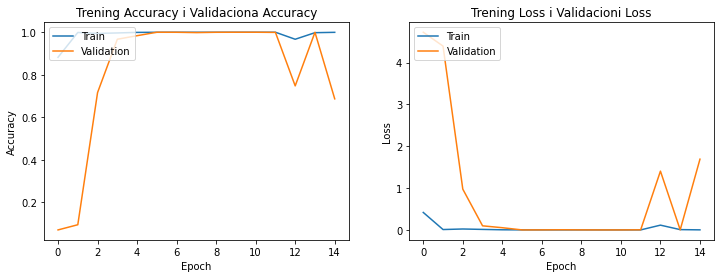

In [11]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Trening Accuracy i Validaciona Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Trening Loss i Validacioni Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

High Validation Accuracy + High Loss Score vs High Training Accuracy + Low Loss Score suggest that the model may be over-fitting on the training data.

In [13]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(75 , (3,3) , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
# convolutional layer
model.add(Conv2D(50 , (3,3) , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
# convolutional layer
model.add(Conv2D(25, (3,3) , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# flatten output of conv
model.add(BatchNormalization())
model.add(Flatten())

# hidden layer
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(units = 24 , activation = 'softmax'))

# compiling the sequential model
model.compile(optimizer = Adam(lr=0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 75)        750       
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 75)        300       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 75)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 50)        33800     
_________________________________________________________________
batch_normalization_9 (Batch (None, 11, 11, 50)        200       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 50)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 25)         

In [16]:
checkpointer = ModelCheckpoint(filepath="models/best_weights.hdf5", verbose=1, save_best_only=True) 

start = datetime.now()
# training the model for 15 epochs
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_val, y_val), 
          callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in: ", duration)

Epoch 1/15
172/172 [==============================] - 227s 1s/step - loss: 1.2885 - accuracy: 0.6840 - val_loss: 3.9139 - val_accuracy: 0.0920

Epoch 00001: val_loss improved from inf to 3.91390, saving model to models\best_weights.hdf5
Epoch 2/15
172/172 [==============================] - 255s 1s/step - loss: 0.1143 - accuracy: 0.9873 - val_loss: 3.4908 - val_accuracy: 0.1639

Epoch 00002: val_loss improved from 3.91390 to 3.49083, saving model to models\best_weights.hdf5
Epoch 3/15
172/172 [==============================] - 225s 1s/step - loss: 0.0265 - accuracy: 0.9990 - val_loss: 0.7739 - val_accuracy: 0.7308

Epoch 00003: val_loss improved from 3.49083 to 0.77392, saving model to models\best_weights.hdf5
Epoch 4/15
172/172 [==============================] - 235s 1s/step - loss: 0.0165 - accuracy: 0.9990 - val_loss: 0.0671 - val_accuracy: 0.9891

Epoch 00004: val_loss improved from 0.77392 to 0.06710, saving model to models\best_weights.hdf5
Epoch 5/15
172/172 [====================

In [17]:
train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

test_score = model.evaluate(x_val, y_val, verbose=1)
print("Validation Accuracy: ", test_score[1])

test_score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

687/687 [==============================] - 119s 173ms/step - loss: 0.0206 - accuracy: 0.9933
Training Accuracy:  0.9933072328567505
172/172 [==============================] - 30s 167ms/step - loss: 0.0266 - accuracy: 0.9905
Validation Accuracy:  0.9905299544334412
225/225 [==============================] - 29s 127ms/step - loss: 0.6019 - accuracy: 0.8511
Test Accuracy:  0.8510875701904297


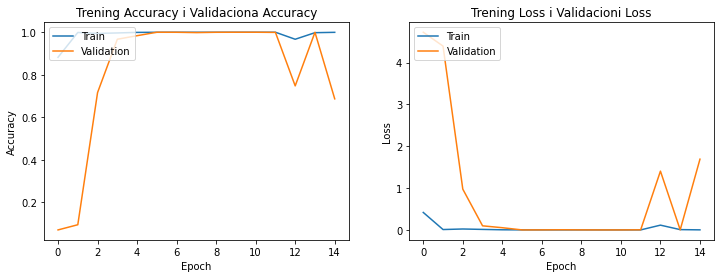

In [18]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Trening Accuracy i Validaciona Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Trening Loss i Validacioni Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()